# Regularization and Evaluation of Neural Networks

In [1]:
from sklearn.datasets import load_sample_images
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
%load_ext autoreload
%autoreload 2

## Agenda

SWBAT:

- use `keras` to code up a neural network model;
- explain dropout and early stopping as distinctive forms of regularization in neural networks;
- use wrappers inside `keras` to make models that can jibe with `sklearn`.

### From last time

In [2]:
digits = load_digits()
X = digits.data
y = digits.target

y_binary = y % 2

In [4]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X.astype('float32'), y_binary.astype('float32'), epochs=50, batch_size=10)

Epoch 1/50
180/180 [==============================] - 0s 891us/step - loss: 0.5295 - accuracy: 0.7613
Epoch 2/50
180/180 [==============================] - 0s 720us/step - loss: 0.2721 - accuracy: 0.8837
Epoch 3/50
180/180 [==============================] - 0s 712us/step - loss: 0.1908 - accuracy: 0.9221
Epoch 4/50
180/180 [==============================] - 0s 738us/step - loss: 0.1509 - accuracy: 0.9460
Epoch 5/50
180/180 [==============================] - 0s 770us/step - loss: 0.1294 - accuracy: 0.9488
Epoch 6/50
180/180 [==============================] - 0s 666us/step - loss: 0.1102 - accuracy: 0.9616
Epoch 7/50
180/180 [==============================] - 0s 554us/step - loss: 0.0976 - accuracy: 0.9616
Epoch 8/50
180/180 [==============================] - 0s 643us/step - loss: 0.0910 - accuracy: 0.9694
Epoch 9/50
180/180 [==============================] - 0s 690us/step - loss: 0.0762 - accuracy: 0.9705
Epoch 10/50
180/180 [==============================] - 0s 579us/step - loss: 0.069

### Things to know:

- The data and labels in `fit()` need to be numpy arrays, not `pandas` dfs.
- Scaling your data will have a large impact on your model.
   > For our traditional input features, we would use a scaler object. For images, as long as the minimum value is 0, we can simply divide through by the maximum pixel intensity.

#### Getting data ready for modeling
**Preprocessing**:

- use train_test_split to create X_train, y_train, X_test, and y_test
- Split training data into pure_train and validation sets.
- Scale the pixel intensity to a value between 0 and 1.

Scaling our input variables will help speed up our neural network.

Since our minimum intensity is 0, we can normalize the inputs by dividing each value by the max value (16).

In [6]:
X_train, X_test, y_train, y_test =\
    train_test_split(X.astype('float32'), y_binary.astype('float32'), random_state=42, test_size=0.2)

X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train, random_state=42, test_size=0.2)

X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

For activation, let's start with the familiar sigmoid function, and see how it performs.

In [7]:
model = Sequential()
# We will start with our trusty sigmoid function.
# What does input dimension correspond to?
model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD' ,
              # We use binary_crossentropy for a binary loss function
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output. To see
# only the metrics at the end of each epoch, set verbose=2.
results = model.fit(X_pure_train, y_pure_train, epochs=10, batch_size=100, verbose=1)

Epoch 1/10
12/12 [==============================] - 0s 1ms/step - loss: 0.6981 - accuracy: 0.4961
Epoch 2/10
12/12 [==============================] - 0s 748us/step - loss: 0.6977 - accuracy: 0.4961
Epoch 3/10
12/12 [==============================] - 0s 914us/step - loss: 0.6974 - accuracy: 0.4961
Epoch 4/10
12/12 [==============================] - 0s 748us/step - loss: 0.6971 - accuracy: 0.4961
Epoch 5/10
12/12 [==============================] - 0s 914us/step - loss: 0.6969 - accuracy: 0.4961
Epoch 6/10
12/12 [==============================] - 0s 749us/step - loss: 0.6967 - accuracy: 0.4970
Epoch 7/10
12/12 [==============================] - 0s 748us/step - loss: 0.6965 - accuracy: 0.4970
Epoch 8/10
12/12 [==============================] - 0s 833us/step - loss: 0.6963 - accuracy: 0.5057
Epoch 9/10
12/12 [==============================] - 0s 914us/step - loss: 0.6962 - accuracy: 0.5117
Epoch 10/10
12/12 [==============================] - 0s 996us/step - loss: 0.6960 - accuracy: 0.5065


We can access the history of our model via `results.history`.
Use __dict__ to take a tour.

In [8]:
results.__dict__

{'validation_data': None,
 'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x2735607cd00>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.6981165409088135,
   0.6977197527885437,
   0.6973809599876404,
   0.6970971822738647,
   0.6968902945518494,
   0.6966598629951477,
   0.6964865922927856,
   0.6962866187095642,
   0.6961854696273804,
   0.6960277557373047],
  'accuracy': [0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4969538748264313,
   0.4969538748264313,
   0.5056570768356323,
   0.5117493271827698,
   0.5065274238586426]},
 'params': {'verbose': 1, 'epochs': 10, 'steps': 12},
 'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

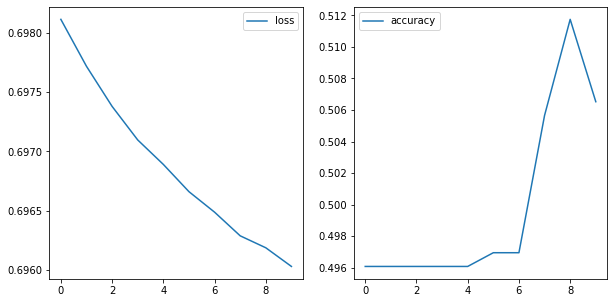

In [9]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=results.history['loss'], ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=results.history['accuracy'], ax=ax2, label='accuracy');

We have two plots above both relating to the quality fo our model.  The left-hand plot is our loss. It uses the probabilities associated with our predictions to judge how well our prediction fits reality. We want it to decrease as far as possible.

The accuracy judges how well the predictions are after applying the threshold at the output layer.  We want accuracy to increase.

If we look at our loss, it is still decreasing. That is a signal that our model is **still learning**. If our model is still learning, we can allow it to get better by turning a few dials.

Let's:
- increase the number of epochs;
- change sigmoid activation in the hidden layers to ReLU; and
- decrease the batch size.

In [10]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output.
results = model.fit(X_pure_train, y_pure_train, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
36/36 [==============================] - 0s 665us/step - loss: 0.6812 - accuracy: 0.4926
Epoch 2/100
36/36 [==============================] - 0s 637us/step - loss: 0.6722 - accuracy: 0.5292
Epoch 3/100
36/36 [==============================] - 0s 720us/step - loss: 0.6667 - accuracy: 0.5918
Epoch 4/100
36/36 [==============================] - 0s 689us/step - loss: 0.6623 - accuracy: 0.6345
Epoch 5/100
36/36 [==============================] - 0s 665us/step - loss: 0.6579 - accuracy: 0.6719
Epoch 6/100
36/36 [==============================] - 0s 596us/step - loss: 0.6532 - accuracy: 0.7006
Epoch 7/100
36/36 [==============================] - 0s 720us/step - loss: 0.6479 - accuracy: 0.7241
Epoch 8/100
36/36 [==============================] - 0s 665us/step - loss: 0.6423 - accuracy: 0.7276
Epoch 9/100
36/36 [==============================] - 0s 693us/step - loss: 0.6360 - accuracy: 0.7581
Epoch 10/100
36/36 [==============================] - 0s 845us/step - loss: 0.6292 - accura

36/36 [==============================] - 0s 665us/step - loss: 0.1347 - accuracy: 0.9408
Epoch 82/100
36/36 [==============================] - 0s 609us/step - loss: 0.1333 - accuracy: 0.9460
Epoch 83/100
36/36 [==============================] - 0s 665us/step - loss: 0.1318 - accuracy: 0.9443
Epoch 84/100
36/36 [==============================] - 0s 637us/step - loss: 0.1307 - accuracy: 0.9452
Epoch 85/100
36/36 [==============================] - 0s 582us/step - loss: 0.1296 - accuracy: 0.9434
Epoch 86/100
36/36 [==============================] - 0s 609us/step - loss: 0.1275 - accuracy: 0.9443
Epoch 87/100
36/36 [==============================] - 0s 609us/step - loss: 0.1263 - accuracy: 0.9478
Epoch 88/100
36/36 [==============================] - 0s 526us/step - loss: 0.1249 - accuracy: 0.9469
Epoch 89/100
36/36 [==============================] - 0s 554us/step - loss: 0.1242 - accuracy: 0.9469
Epoch 90/100
36/36 [==============================] - 0s 637us/step - loss: 0.1223 - accuracy: 

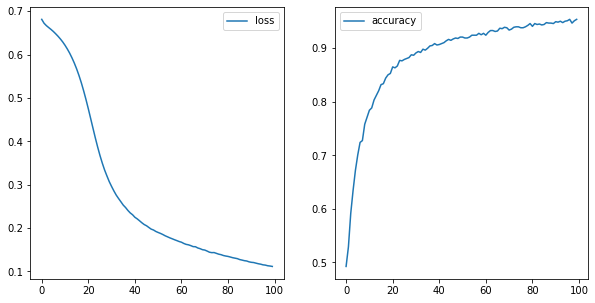

In [11]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

If we increase the learning rate to a very high number, we see that our model overshoots the minimum, and starts bouncing all around.

Epoch 1/30
115/115 [==============================] - 0s 722us/step - loss: 1.5182 - accuracy: 0.5161
Epoch 2/30
115/115 [==============================] - 0s 764us/step - loss: 1.0629 - accuracy: 0.4848
Epoch 3/30
115/115 [==============================] - 0s 710us/step - loss: 1.0228 - accuracy: 0.5004
Epoch 4/30
115/115 [==============================] - 0s 744us/step - loss: 0.9935 - accuracy: 0.4952
Epoch 5/30
115/115 [==============================] - 0s 716us/step - loss: 1.0288 - accuracy: 0.4970
Epoch 6/30
115/115 [==============================] - 0s 694us/step - loss: 1.0277 - accuracy: 0.4787
Epoch 7/30
115/115 [==============================] - 0s 668us/step - loss: 1.0002 - accuracy: 0.5117
Epoch 8/30
115/115 [==============================] - 0s 644us/step - loss: 0.9871 - accuracy: 0.5013
Epoch 9/30
115/115 [==============================] - 0s 664us/step - loss: 1.0909 - accuracy: 0.4778
Epoch 10/30
115/115 [==============================] - 0s 798us/step - loss: 1.024

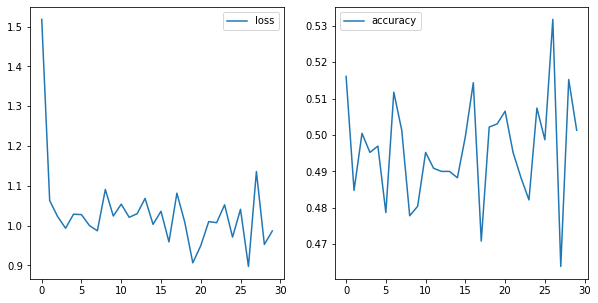

In [12]:
model = Sequential()

sgd = SGD(lr=9)
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=sgd,
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                    epochs=30, batch_size=10, verbose=1)

relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy');

### Exercise

We have been looking only at our training set. Let's add in our validation set to the picture. Check the docstring for the `.fit()` method and add in our validation data.

In [ ]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


## YOUR CODE HERE


train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(results.epoch, train_loss, ax=ax1, label='train_loss')
sns.lineplot(results.epoch, train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(results.epoch, val_loss, ax=ax1, label='val_loss')
sns.lineplot(results.epoch, val_acc, ax=ax2, label='val_accuracy');

In [ ]:
results.history['val_accuracy'][-1]

## Connecting with `sklearn`

The `keras.wrappers` submodule means that we can turn `keras` models into estimators that `sklearn` tools will recognize.

In [ ]:
# This will throw an error.

cross_val_score(model, X_pure_train, y_pure_train)

In [ ]:
def build_model():
    model = Sequential()
    model.add(Dense(12, activation='relu', input_dim=64))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
keras_model = scikit_learn.KerasClassifier(build_model,
                                          epochs=50,
                                          batch_size=32,
                                          verbose=2)

In [ ]:
type(keras_model)

In [ ]:
cross_val_score(keras_model, X_pure_train, y_pure_train)

## Regularization

Does regularization make sense in the context of neural networks? <br/>

Yes! We still have all of the salient ingredients: a loss function, overfitting vs. underfitting, and coefficients (weights) that could get too large.

But there are now a few different flavors besides L1 and L2 regularization. (Note that L1 regularization is not common in the context of  neural networks.)

We'll add a few more layers to give regularization a better chance of making a difference!

In [ ]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))

# We can add L2 (or L1) regularization right into
# the layer with the kernel_regularizer parameter.

model.add(Dense(20, activation='relu',
                kernel_regularizer=l2(l2=0.05)))

# Note that there is also a bias_regularizer,
# but this tends to have less effect.

model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

Adding L2 to multiple layers:

In [ ]:
model = Sequential()
model.add(Dense(30, activation='relu',
                input_dim=64))
model.add(Dense(20, activation='relu',
                kernel_regularizer=l2(l2=0.01)))

model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(8, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(4, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

### Dropout

We can also specify a dropout layer in keras, which randomly shuts off different nodes during training. This can help to prevent overfitting.

![drop_out](img/drop_out.png)

### Exercise

To add dropout to a `keras` network, simply add it as though it were a layer. It will apply to the immediately preceding layer.

Add Dropout to one or more layers below.

In [ ]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=50,
                    batch_size= 32, verbose=0,
                    validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

### Early Stopping

We can also tell our neural network to stop once it stops realizing any gain.

Here we tell it to stop once the a very small positive change in the validation loss occurs:

In [ ]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           verbose=1,
                           mode='min')

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

### Exercise

That probably stopped too early. We can specify the number of epochs in which it doesn't see decrease in the loss with the `patience` parameter. Modify the code below to include an Early Stop with a patience of 5 epochs.

In [ ]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object

early_stop = ## YOUR CODE HERE

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=50, batch_size= 32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

## Multiclass Classification and Softmax

Now let's return to the problem of predicting digits 0 through 9.

In [ ]:
digits = load_digits()
X = digits.data
y = digits.target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)
X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train,
                     random_state=42, test_size=0.2)
X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

For a multiclass output, our neural net expects our target to be in a certain form.

In [ ]:
ohe = OneHotEncoder(sparse=False)
y_pure_train = ohe.fit_transform(y_pure_train.reshape(-1,1))
y_val = ohe.transform(y_val.reshape(-1,1))
y_test = ohe.transform(y_test.reshape(-1,1))

In [ ]:
y_test

In [ ]:
# Model from above, but now with ten output neurons:

model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                   epochs=50, batch_size=10,
                   validation_data=(X_val, y_val))

$$\large \text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$$

The sofmax function outputs a number between 0 and 1 for each of our classes.  All of the probabilities of the classes sum up to 1.

The number of nodes in our output layer equals the number of categories in our dataset.

We also need a new loss function: **categorical crossentropy**, which calculates a separate loss for each label and then sums the results.

In [ ]:
history = results.history
training_loss = history['loss']
val_loss = history['val_loss']
training_accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))


sns.lineplot(x=list(range(len(training_loss))),
             y=training_loss, color='r', label='training', ax=ax1)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_loss, color='b', label='validation', ax=ax1)
sns.lineplot(x=list(range(len(training_loss))),
             y=training_accuracy, color='r', label='training',ax=ax2)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_accuracy, color='b', label='validation',ax=ax2)
ax1.legend();

In [ ]:
y_hat_test = np.argmax(model.predict(X_test), axis=-1)

In [ ]:
y_test_restore = ohe.inverse_transform(y_test)
confusion_matrix(y_test_restore, y_hat_test)

Wow, look at that performance!  

That is great, but remember, we were dealing with simple black and white images.  With color, our basic neural net will have less success.

We will explore more advanced tools in the coming days.


## Appendix: More on Tensorflow Vs. Keras


### Let's start with tensors

Tensors are multidimensional matrices.

![tensor](img/tensors.png)

### TensorFlow manages the flow of matrix math

That makes neural network processing possible.

![cat](img/cat-tensors.gif)

For our numbers dataset, our tensors from the `sklearn` dataset were originally tensors of the shape 8x8, i.e. 64-bit pictures. Remember, that was with black and white images.

For image processing, we are often dealing with color.

In [ ]:
image = load_sample_images()['images'][0]

imgplot = plt.imshow(image)

In [ ]:
image.shape

What do the dimensions of our image above represent?

Tensors with higher numbers of dimensions have a higher **rank**.

A matrix with rows and columns only, like the black and white numbers, has **rank 2**.

A matrix with a third dimension, like the color pictures above, has **rank 3**.

When we flatten an image by stacking the rows in a column, we are decreasing the rank. 

In [ ]:
flat_image = image.reshape(-1, 1)

flat_image.shape

In [ ]:
427*640*3

## TensorFlow has more levers and buttons, but Keras is more user-friendly

Coding directly in **Tensorflow** allows you to tweak more parameters to optimize performance. The **Keras** wrapper makes the code more accessible for developers prototyping models.

![levers](img/levers.jpeg)

### Keras, an API with an intentional UX

- Deliberately design end-to-end user workflows
- Reduce cognitive load for your users
- Provide helpful feedback to your users

[full article here](https://blog.keras.io/user-experience-design-for-apis.html)<br>
[full list of why to use Keras](https://keras.io/why-use-keras/)

### A few comparisons

While you **can leverage both**, here are a few comparisons.

| Comparison | Keras | Tensorflow|
|------------|-------|-----------|
| **Level of API** | high-level API | High and low-level APIs |
| **Speed** |  can *seem* slower |  is a bit faster |
| **Language architecture** | simple architecture, more readable and concise | straight tensorflow is a bit more complex |
| **Debugging** | less frequent need to debug | difficult to debug |
| **Datasets** | usually used for small datasets | high performance models and large datasets that require fast execution|

This is also a _**non-issue**_ - as you can leverage `tensorflow` commands within `keras` and vice versa. If Keras ever seems slower, it's because the developer's time is more expensive than the GPUs'. Keras is designed with the developer in mind. 

[reference link](https://www.edureka.co/blog/keras-vs-tensorflow-vs-pytorch/)